# Measurement Error Mitigation

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.visualization import array_to_latex

### Introduction

The effect of noise is to give us outputs that are not quite correct. The effect of noise that occurs throughout a computation will be quite complex in general, as one would have to consider how each gate transforms the effect of each error.

A simpler form of noise is that occurring during final measurement. At this point, the only job remaining in the circuit is to extract a bit string as an output. For an $n$ qubit final measurement, this means extracting one of the $2^n$ possible $n$ bit strings. As a simple model of the noise in this process, we can imagine that the measurement first selects one of these outputs in a perfect and noiseless manner, and then noise subsequently causes this perfect output to be randomly perturbed before it is returned to the user.

Given this model, it is very easy to determine exactly what the effects of measurement errors are. We can simply prepare each of the $2^n$ possible basis states, immediately measure them, and see what probability exists for each outcome.

As an example, we will first create a simple noise model, which randomly flips each bit in an output with probability $p$.

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

Let's start with an instance of this in which each bit is flipped $1\%$ of the time.

In [3]:
noise_model = get_noise(0.01)

Now we can test out its effects. Specifically, let's define a two qubit circuit and prepare the states $\left|00\right\rangle$, $\left|01\right\rangle$, $\left|10\right\rangle$ and $\left|11\right\rangle$. Without noise, these would lead to the definite outputs `'00'`, `'01'`, `'10'` and `'11'`, respectively. Let's see what happens with noise. Here, and in the rest of this section, the number of samples taken for each circuit will be `shots=10000`.

In [4]:
aer_sim = Aer.get_backend('aer_simulator')
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure([0, 1], [0, 1])
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc)
    counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
    print(state+' becomes', counts)

00 becomes {'01': 83, '11': 3, '10': 98, '00': 9816}
01 becomes {'10': 1, '00': 96, '11': 92, '01': 9811}


/Users/tianyiwang/opt/anaconda3/envs/idp/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/tianyiwang/opt/anaconda3/envs/idp/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


10 becomes {'01': 2, '00': 88, '11': 96, '10': 9814}
11 becomes {'01': 92, '00': 1, '10': 89, '11': 9818}


Here we find that the correct output is certainly the most dominant. Ones that differ on only a single bit (such as `'01'`, `'10'` in the case that the correct output is `'00'` or `'11'`), occur around $1\%$ of the time. Those that differ on two bits occur only a handful of times in 10000 samples, if at all.

So what about if we ran a circuit with this same noise model, and got an result like the following?

```
{'10': 98, '11': 4884, '01': 111, '00': 4907}
```

Here `'01'` and `'10'` occur for around $1\%$ of all samples. We know from our analysis of the basis states that such a result can be expected when these outcomes should in fact never occur, but instead the result should be something that differs from them by only one bit: `'00'` or `'11'`. When we look at the results for those two outcomes, we can see that they occur with roughly equal probability. We can therefore conclude that the initial state was not simply $\left|00\right\rangle$, or $\left|11\right\rangle$, but an equal superposition of the two. If true, this means that the result should have been something along the lines of:

```
{'11': 4977, '00': 5023}
```

Here is a circuit that produces results like this (up to statistical fluctuations).

In [5]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0, 1], [0, 1])
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
print(counts)

{'01': 105, '10': 93, '11': 4864, '00': 4938}


In this example we first looked at results for each of the definite basis states, and used these results to mitigate the effects of errors for a more general form of state. This is the basic principle behind measurement error mitigation.

### Error mitigation with linear algebra

Now we just need to find a way to perform the mitigation algorithmically rather than manually. We will do this by describing the random process using matrices. For this we need to rewrite our counts dictionaries as column vectors. For example, the dictionary `{'10': 96, '11': 1, '01': 95, '00': 9808}` would be rewritten as

$$
C = 
\begin{pmatrix}
    9808 \\
    95 \\
    96 \\
    1
\end{pmatrix}.
$$

Here the first element is that for `'00'`, the next is that for `'01'`, and so on.

The information gathered from the basis states $\left|00\right\rangle$, $\left|01\right\rangle$, $\left|10\right\rangle$ and $\left|11\right\rangle$ can then be used to define a matrix, which rotates from an ideal set of counts to one affected by measurement noise. This is done by simply taking the counts dictionary for $\left|00\right\rangle$, normalizing it so that all elements sum to one, and then using it as the first column of the matrix. The next column is similarly defined by the counts dictionary obtained for $\left|01\right\rangle$, and so on. 

There will be statistical variations each time the circuit for each basis state is run. In the following, we will use the data obtained when this section was written, which was as follows.

```
00 becomes {'10': 96, '11': 1, '01': 95, '00': 9808}
01 becomes {'10': 2, '11': 103, '01': 9788, '00': 107}
10 becomes {'10': 9814, '11': 90, '01': 1, '00': 95}
11 becomes {'10': 87, '11': 9805, '01': 107, '00': 1}
```

This gives us the following matrix.

$$
M = 
\begin{pmatrix}
    0.9808&0.0107&0.0095&0.0001 \\
    0.0095&0.9788&0.0001&0.0107 \\
    0.0096&0.0002&0.9814&0.0087 \\
    0.0001&0.0103&0.0090&0.9805
\end{pmatrix}
$$

If we now take the vector describing the perfect results for a given state, applying this matrix gives us a good approximation of the results when measurement noise is present.



$$ C_{noisy} = M ~ C_{ideal}$$

.

As an example, let's apply this process for the state $(\left|00\right\rangle+\left|11\right\rangle)/\sqrt{2}$, 

$$
\begin{pmatrix}
    0.9808&0.0107&0.0095&0.0001 \\
    0.0095&0.9788&0.0001&0.0107 \\
    0.0096&0.0002&0.9814&0.0087 \\
    0.0001&0.0103&0.0090&0.9805
\end{pmatrix}
\begin{pmatrix}
    5000 \\
    0 \\
    0 \\
    5000
\end{pmatrix}
=
\begin{pmatrix}
    4904.5 \\
    101 \\
    91.5 \\
    4903
\end{pmatrix}.
$$

In code, we can express this as follows.

In [6]:
import numpy as np

M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

Cideal = [[5000],
          [0],
          [0],
          [5000]]

Cnoisy = np.dot(M, Cideal)
array_to_latex(Cnoisy, prefix="\\text{C}_\\text{noisy} = ")

<IPython.core.display.Latex object>

Either way, the resulting counts found in $C_{noisy}$, for measuring the $(\left|00\right\rangle+\left|11\right\rangle)/\sqrt{2}$ with measurement noise, come out quite close to the actual data we found earlier. So this matrix method is indeed a good way of predicting noisy results given a knowledge of what the results should be.

Unfortunately, this is the exact opposite of what we need. Instead of a way to transform ideal counts data into noisy data, we need a way to transform noisy data into ideal data. In linear algebra, we do this for a matrix $M$ by finding the inverse matrix $M^{-1}$,



$$C_{ideal} = M^{-1} C_{noisy}.$$




In [7]:
import scipy.linalg as la

M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

Minv = la.inv(M)

array_to_latex(Minv)

<IPython.core.display.Latex object>

Applying this inverse to $C_{noisy}$, we can obtain an approximation of the true counts.

In [8]:
Cmitigated = np.dot(Minv, Cnoisy)
array_to_latex(Cmitigated, prefix="\\text{C}_\\text{mitigated}=")

<IPython.core.display.Latex object>

Of course, counts should be integers, and so these values need to be rounded. This gives us a very nice result.
$$
C_{mitigated} = 
\begin{pmatrix}
    5000 \\
    0 \\
    0 \\
    5000
\end{pmatrix}
$$

This is exactly the true result we desire. Our mitigation worked extremely well!

### Error mitigation in Qiskit

In [9]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

/var/folders/rs/102x81n53kx_bl5zxtvgy0fc0000gn/T/ipykernel_61810/2184433781.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


The process of measurement error mitigation can also be done using tools from Qiskit. This handles the collection of data for the basis states, the construction of the matrices and the calculation of the inverse. The latter can be done using the pseudo inverse, as we saw above. However, the default is an even more sophisticated method using least squares fitting.

As an example, let's stick with doing error mitigation for a pair of qubits. For this we define a two qubit quantum register, and feed it into the function `complete_meas_cal`.

In [10]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

This creates a set of circuits to take measurements for each of the four basis states for two qubits: $\left|00\right\rangle$, $\left|01\right\rangle$, $\left|10\right\rangle$ and $\left|11\right\rangle$.

In [11]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q10_0: ─░─┤M├───
        ░ └╥┘┌─┐
q10_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c0_0: ════╩══╬═
              ║ 
 c0_1: ═══════╩═
                

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q10_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q10_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c0_0: ═════════╩══╬═
                   ║ 
 c0_1: ════════════╩═
                     

Circuit mcalcal_10
             ░ ┌─┐   
q10_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q10_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0_0: ═════════╩══╬═
                   ║ 
 c0_1: ════════════╩═
                     

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q10_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q10_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0_0: ═════════╩══╬═
                   ║ 
 c0_1: ════════════╩═
                     



Let's now run these circuits without any noise present.

In [12]:
# Execute the calibration circuits without noise
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, shots=10000).result()

/Users/tianyiwang/opt/anaconda3/envs/idp/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/tianyiwang/opt/anaconda3/envs/idp/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


With the results we can construct the calibration matrix, which we have been calling $M$.

In [13]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

With no noise present, this is simply the identity matrix.

Now let's create a noise model. And to make things interesting, let's have the errors be ten times more likely than before.

In [14]:
noise_model = get_noise(0.1)

Again we can run the circuits, and look at the calibration matrix, $M$.

In [15]:
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

This time we find a more interesting matrix, and one that we cannot use in the approach that we described earlier. Let's see how well we can mitigate for this noise. Again, let's use the Bell state $(\left|00\right\rangle+\left|11\right\rangle)/\sqrt{2}$ for our test.

In [16]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0, 1], [0, 1])

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'01': 899, '10': 886, '00': 4125, '11': 4090}


In Qiskit we mitigate for the noise by creating a measurement filter object. Then, taking the results from above, we use this to calculate a mitigated set of counts. Qiskit returns this as a dictionary, so that the user doesn't need to use vectors themselves to get the result.

In [17]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

To see the results most clearly, let's plot both the noisy and mitigated results.

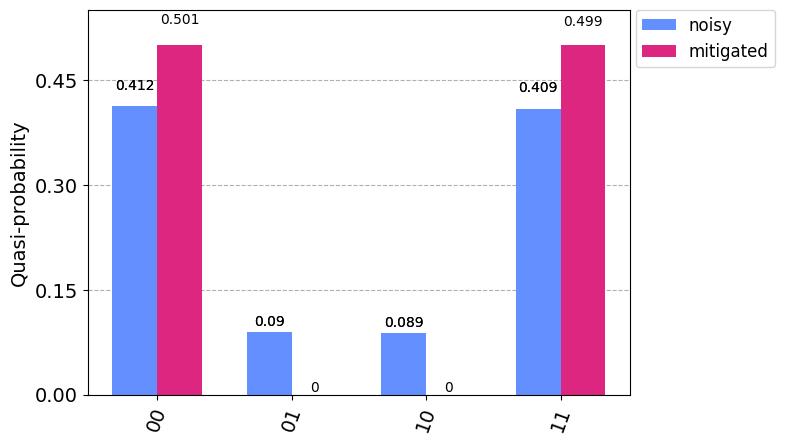

In [18]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

Here we have taken results for which almost $20\%$ of samples are in the wrong state, and turned it into an exact representation of what the true results should be. However, this example does have just two qubits with a simple noise model. For more qubits, and more complex noise models or data from real devices, the mitigation will have more of a challenge. Perhaps you might find methods that are better than those Qiskit uses!

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table